# What

As established in [#144](https://github.com/1jamesthompson1/TAIC-report-summary/issues/144) now that we have the safety issues dataset from #141 it is possible for us to generate the safety themes just from the safety issues.

This is supposed to be a quick example of how it could be done and what this dataset could be used for.

## Modules

To make this document easy to move all the modules needed are listed here

In [32]:
# from engine
from engine.OpenAICaller import openAICaller

from engine.Extract_Analyze import ThemeGenerator

# third party
import yaml
import pandas as pd
import numpy as np

from dotenv import load_dotenv
load_dotenv('../../.env')

import voyageai

import lancedb
from bertopic import BERTopic
from bertopic.representation import OpenAI

import openai

from sentence_transformers import SentenceTransformer
from huggingface_hub import get_inference_endpoint, list_inference_endpoints


# built in
import os
import importlib
import requests

importlib.reload(ThemeGenerator)

client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


# Get data

I am going to read all of the safety issues from the reports.

After discussion and the lacklustre expected performance I am going to try to add more context to the safety issues. I will try doing this by merging in the linked recommendations

## Safety themes

In [140]:
output_path = "output"

safety_issues = []

all_reports = [r for r in os.listdir(output_path) if os.path.isdir(os.path.join(output_path, r))] 

for report_id in all_reports:
    
    safety_issue_path = os.path.join(output_path, report_id, f"{report_id}_safety_issues.yaml")

    if not os.path.exists(safety_issue_path):
        continue

    with open(os.path.join(output_path, report_id, f"{report_id}_safety_issues.yaml"), "r") as f:
        si = yaml.safe_load(f)

    safety_issues.append({
        'report_id': report_id,
        'si': si
    })

In [142]:
safety_issues_df = pd.DataFrame(safety_issues)

safety_issues_df = safety_issues_df.explode('si').reset_index(drop=True)

safety_issues_df['quality'] = safety_issues_df['si'].apply(lambda x: x['quality'])
safety_issues_df['si'] = safety_issues_df['si'].apply(lambda x: x['safety_issue'].strip())

safety_issues_df['mode'] = safety_issues_df['report_id'].apply(lambda x: int(x[5]))

safety_issues_df

,report_id,si,quality,mode
0,2019_106,No procedures were in place to direct train cr...,exact,1
1,2013_107,"The high incidence of brake block replacement,...",inferred,1
2,2013_107,The visual inspection regime for wheel-bearing...,inferred,1
3,2013_107,"The RailBAM system, while operational, did not...",inferred,1
4,2013_107,The lack of a dedicated RailBAM analyst positi...,inferred,1
...,...,...,...,...
555,2011_006,The CAA had had recurring concerns for the man...,exact,0
556,2017_003,The maintenance inspection programme for the l...,exact,0
557,2017_104,Transdev had no policies or procedures in plac...,exact,1
558,2020_104,Implementation of an administrative control me...,exact,1


In [5]:
safety_issues_df.to_csv("safety_issues.csv", index=False)

<Axes: >

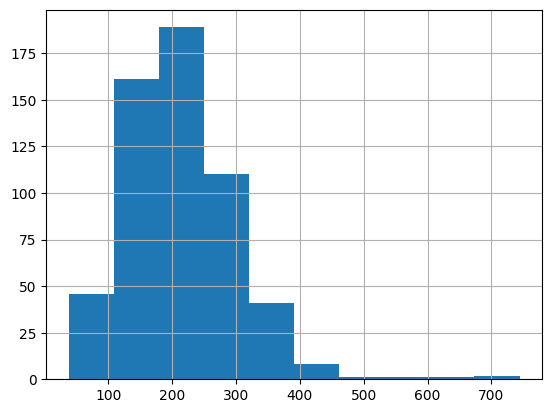

In [6]:
# Get some stats on the data and SI length

safety_issues_df['si_length'] = safety_issues_df['si'].apply(lambda x: len(x))

safety_issues_df['si_length'].hist()

## Recommendations

In [143]:
# Read in from files

output_path = "output"
def get_all_recommendations(output_path):
    
    recommendations = pd.DataFrame()

    all_reports = [r for r in os.listdir(output_path) if os.path.isdir(os.path.join(output_path, r))] 

    for report_id in all_reports:
        
        recommendations_path = os.path.join(output_path, report_id, f"{report_id}_recommendation_safety_issue_links.csv")

        if not os.path.exists(recommendations_path):
            continue

        recomendation_df = pd.read_csv(recommendations_path)

        recommendations = pd.concat([recommendations, recomendation_df])

    return recommendations.reset_index(drop=True)


recommendations_df = get_all_recommendations(output_path)

In [144]:
# Prepare for merge

recommendations_df = recommendations_df.query('link == "Confirmed"').reset_index(drop=True)

recommendations_df['si'] = recommendations_df['safety_issue'].apply(lambda x: x.strip())

recommendations_df

,report_id,recommendation_id,recommendation,extra_recommendation_context,safety_issue,quality,link,si
0,2013_107,001/16,The Commission recommends that the chief execu...,NaN,"The high incidence of brake block replacement,...",inferred,Confirmed,"The high incidence of brake block replacement,..."
1,2011_003,003/14,On 26 February 2014 the Commission recommended...,NaN,The New Zealand regulatory system has not prov...,exact,Confirmed,The New Zealand regulatory system has not prov...
2,2011_003,004/14,On 26 February 2014 the Commission recommended...,NaN,The New Zealand regulatory system has not prov...,exact,Confirmed,The New Zealand regulatory system has not prov...
3,2011_003,004/14,On 26 February 2014 the Commission recommended...,NaN,The rate of R22 in-flight break-up accidents i...,exact,Confirmed,The rate of R22 in-flight break-up accidents i...
4,2011_003,005/14,On 26 February 2014 the Commission recommended...,NaN,"The crashworthiness of the ELT, which was desi...",exact,Confirmed,"The crashworthiness of the ELT, which was desi..."
...,...,...,...,...,...,...,...,...
376,2011_006,001/14,On 26 February 2014 the Commission recommended...,NaN,The standard of pilot training and the supervi...,exact,Confirmed,The standard of pilot training and the supervi...
377,2011_006,001/14,On 26 February 2014 the Commission recommended...,NaN,The CAA had had recurring concerns for the man...,exact,Confirmed,The CAA had had recurring concerns for the man...
378,2011_006,002/14,On 26 February 2014 the Commission recommended...,NaN,The council had not evaluated the effects of t...,exact,Confirmed,The council had not evaluated the effects of t...
379,2017_104,001/19,the Commission recommended that Transdev Auckl...,The training that the train crew had received ...,Transdev had no policies or procedures in plac...,exact,Confirmed,Transdev had no policies or procedures in plac...


## Merge safety issues and recommendations togather

In [228]:
merged_si_recs = safety_issues_df.merge(recommendations_df, on='si', suffixes=(None, "_recs"), how='left')

# Merge recommendations into list of recommendation for each si

merged_si_recs = (merged_si_recs.groupby(['report_id', 'si'])
                  .agg({
                      'recommendation': list,
                      'extra_recommendation_context': list,
                      'quality': 'first',
                      'mode': 'first',
                      'recommendation_id': list})
                  .reset_index())

merged_si_recs['recommendations'] = merged_si_recs.apply(lambda row: [{'recommendation': rec, 
                                                                       'extra_context': extra, 
                                                                       'recommendation_id': rec_id} 
                                                                      for rec, extra, rec_id 
                                                                      in zip(row['recommendation'], 
                                                                             row['extra_recommendation_context'], 
                                                                             row['recommendation_id'])
                                                                        if not all(pd.isna([rec, rec_id]))], 
                                                         axis=1)

# Drop the individual columns after merging
merged_si_recs.drop(['recommendation', 'extra_recommendation_context', 'recommendation_id'], axis=1, inplace=True)


merged_si_recs

,report_id,si,quality,mode,recommendations
0,2010_001,Airways also required controllers to pass pire...,inferred,0,[]
1,2010_001,Airways required all pireps to be passed to Me...,inferred,0,[]
2,2010_001,Limitations in the operator's dispatch system ...,inferred,0,[]
3,2010_001,The first air traffic controller did not hear ...,inferred,0,[]
4,2010_001,The report of loose objects on one flight deck...,inferred,0,[]
...,...,...,...,...,...
555,2020_103,There was no evidence that the rail industry h...,exact,1,[{'recommendation': 'The Commission recommende...
556,2020_104,Implementation of an administrative control me...,exact,1,[]
557,2020_104,The use of an administrative control measure w...,exact,1,"[{'recommendation': 'On 8 December 2021, the C..."
558,2020_201,The deckhand keeping watch on board the Leila ...,exact,2,[{'recommendation': 'On 27 May 2021 the Commis...


In [229]:
merged_si_recs['recommendation_text'] = merged_si_recs['recommendations'].apply(
    lambda recs:
    "\n".join([f"Recommendation {rec['recommendation_id']}: {rec['recommendation']}" for rec in recs])
)

merged_si_recs

merged_si_recs['si'] = merged_si_recs.apply(
    lambda row:
    f"Safety issue: {row['si']}\n\n{'There were these recommendations made to address the safety issues.' if not row['recommendation_text'] == '' else ''}\n{row['recommendation_text'] if not row['recommendation_text'] == '' else ''}",
    axis = 1
)

merged_si_recs.drop(columns='recommendation_text', inplace=True)

merged_si_recs

,report_id,si,quality,mode,recommendations
0,2010_001,Safety issue: Airways also required controller...,inferred,0,[]
1,2010_001,Safety issue: Airways required all pireps to b...,inferred,0,[]
2,2010_001,Safety issue: Limitations in the operator's di...,inferred,0,[]
3,2010_001,Safety issue: The first air traffic controller...,inferred,0,[]
4,2010_001,Safety issue: The report of loose objects on o...,inferred,0,[]
...,...,...,...,...,...
555,2020_103,Safety issue: There was no evidence that the r...,exact,1,[{'recommendation': 'The Commission recommende...
556,2020_104,Safety issue: Implementation of an administrat...,exact,1,[]
557,2020_104,Safety issue: The use of an administrative con...,exact,1,"[{'recommendation': 'On 8 December 2021, the C..."
558,2020_201,Safety issue: The deckhand keeping watch on bo...,exact,2,[{'recommendation': 'On 27 May 2021 the Commis...


# Use gpt 4 to generate safety themes

I am now going to run it through a LLM.

After attempting this using the engines current method I am going to try again to do it with vector embeddings and clustering them together. This is because we want more transparent and robust.

## Prompt preparation

In [3]:
safety_issues_str = ""

for si in safety_issues:
    si_str = "\n".join([i['safety_issue'] for i in si['si']])
            
    safety_issues_str += f"Report ID: {si['report_id']}\n{si_str}\n"

## Sending to model

In [4]:
importlib.reload(ThemeGenerator)

themeGenerator = ThemeGenerator.ThemeGenerator(output_path, {"folder_name": "{{report_id}}", "themes_file_name": "{{report_id}}_themes.yaml"}, ['aviation', 'rail', 'marine'], False)

## Getting safety themes

In [7]:
safety_theme_example = themeGenerator._get_safety_themes_from_reports(safety_issues_str)

In [ ]:
safety_themes = [themeGenerator._get_safety_themes_from_reports(safety_issues_str) for _ in range(3)]


In [ ]:
# Get the average

safety_themes_str = [
    '\n'.join([f"{safety_theme['title'].strip()} for modes {', '.join(safety_theme['modes'])}:\n {safety_theme['description']}" for safety_theme in safety_themes_set])
    for safety_themes_set in safety_themes
]

safety_themes_str = '\n\n'.join([f"Safety themes version\n'''\n{themes}\n'''\n" for themes in safety_themes_str])

print(safety_themes_str)


In [142]:

average_safety_theme = openAICaller.query(
    system="""
You are going to help me summarize the given source text.
        """,

    user=f"""
Here is the text to summarize:
'''
{safety_themes_str}
'''

Here are three versions of the safety themes extracted from a collection of accident investigation reports.

I need you to return one set that is the average of all of the safety themes versions. This means it there should be about 15 final safety themes.

Your output needs to be in yaml format. Just output the yaml structure with no extra text (This means no ```yaml and ```) . It will look something like this:
- title: |-
    title of the theme goes here
    description: |
    Multi line description of the theme goes here.
    modes:
    - modes that should be included. One per row (Each mode is just one letter (a,r,m))


=Here are some definitions=

Safety factor - Any (non-trivial) events or conditions, which increases safety risk. If they occurred in the future, these would
increase the likelihood of an occurrence, and/or the
severity of any adverse consequences associated with the
occurrence.

Safety issue - A safety factor that:
• can reasonably be regarded as having the
potential to adversely affect the safety of future
operations, and
• is characteristic of an organization, a system, or an
operational environment at a specific point in time.
Safety Issues are derived from safety factors classified
either as Risk Controls or Organizational Influences.

Safety theme - Indication of recurring circumstances or causes, either across transport modes or over time. A safety theme may
cover a single safety issue, or two or more related safety
issues.    

        """,
    model = 'gpt-4',
    temp=0
)
try:
    average_safety_theme = yaml.safe_load(average_safety_theme)
except yaml.YAMLError:
    print("Cant parse")
    print(average_safety_theme)


yaml.safe_dump(average_safety_theme, open("safety_themes.yaml", "w"))

In [ ]:
safety_themes = yaml.safe_load(open("safety_themes.yaml", "r"))

print(len(safety_themes))

safety_themes

## Grouping safety themes

In [148]:
safety_theme_groups = themeGenerator._group_safety_themes(safety_themes)

In [11]:
# Edit each title to remove trailing newline

for group in safety_theme_example:
    group['title'] = group['title'].strip()


safety_theme_example

[{'title': 'Non-compliance with Procedures',
  'description': 'This theme involves instances where individuals or teams do not adhere to established safety procedures, protocols, or regulations. This can include failure to follow standard operating procedures, maintenance protocols, or regulatory requirements. Non-compliance can lead to unsafe conditions, increased risk of accidents, and potential harm. It underscores the importance of strict adherence to safety guidelines and the need for robust oversight and training to ensure compliance.\n',
  'modes': ['a', 'r', 'm']},
 {'title': 'Inadequate Communication',
  'description': 'Inadequate communication refers to failures or deficiencies in the exchange of critical information among team members, between different teams, or with external entities. This can include miscommunication, lack of clarity, or failure to share important safety-related information. Such communication failures can lead to misunderstandings, misaligned actions, an

In [12]:


safety_theme_groups_example = themeGenerator._group_safety_themes(safety_theme_example)

In [149]:
safety_theme_groups

[{'title': 'Human Factors and Training',
  'description': 'This group focuses on the human element in operational safety, emphasizing the importance of training, non-technical skills, and managing human vulnerabilities such as fatigue.\n',
  'themes': ['Inadequate Training and Familiarization',
   'Human Factors and Non-Technical Skills',
   'Fatigue Management']},
 {'title': 'Safety Management and Organizational Practices',
  'description': 'Themes in this group relate to the overarching systems and cultural practices within organizations that support or undermine safety, including the management of safety information and the cultivation of a safety culture.\n',
  'themes': ['Safety Management Systems Deficiencies',
   'Safety Culture and Organizational Influences',
   'Regulatory and Oversight Deficiencies']},
 {'title': 'Operational and Technical Safeguards',
  'description': 'This group encompasses the technical and procedural aspects of safety, focusing on the design, maintenance,

## Add groups to original safety themes

In [14]:
# Add a field to each safety theme that is the group it belongs to

def combine_groups_with_themes(safety_theme_groups, safety_themes):

    safety_themes_with_groups = []

    for theme in safety_themes:
        for group in safety_theme_groups:
            if theme['title'] in group['themes']:
                theme['group'] = group['title']
                safety_themes_with_groups.append(theme)
                break

    return safety_themes_with_groups

In [15]:
safety_theme_example_with_groups = combine_groups_with_themes(safety_theme_groups_example, safety_theme_example)

## Prepare xlsx spreadsheet to share with chris and ingrid

I need to give a spreadsheet to them so that they can appreicate what the results are.

In [13]:
# First page has all the safety themes
# Second page has the groups

def send_to_excel(safety_themes_with_groups, safety_theme_groups, file_name):

    writer = pd.ExcelWriter("generated_safety_themes.xlsx", engine="openpyxl")

    pd.DataFrame(safety_themes_with_groups)[['title', 'description', 'group']].to_excel(writer, sheet_name="Safety Themes", index=False)

    pd.DataFrame(safety_theme_groups).to_excel(writer, sheet_name="Safety Theme Groups", index=False)

    writer.close()

In [16]:
send_to_excel(safety_theme_example_with_groups, safety_theme_groups_example, "safety_themes.xlsx")

After performing this multiple times I am noticing that it varies a bit.

I would like to take an average.

# Generating safety themes with clustering

As per https://github.com/1jamesthompson1/TAIC-report-summary/issues/144#issuecomment-2084207763 a different method will be looked into for safety theme generation.

This will be embedding the safety issues and then clustering them.

Currently i am looking at VoyageAI and OpenAI.

However it might be better to try out some other embedding models for example:
- https://huggingface.co/Alibaba-NLP/gte-Qwen1.5-7B-instruct


These will require me to setup dedicated endpoints.

In [28]:
def put_embeddings_into_vectorDB(df, tbl_name):
    if not df.columns.isin(['vector']).any():
        print("Given dataframe is missing 'vector' column")
        return None
    
    uri = "checking_embeddings_db"

    db = lancedb.connect(uri)

    if tbl_name in db.table_names():
        db.drop_table(tbl_name)

    tbl = db.create_table(tbl_name, df)

    return tbl

## Opensource

These open source ones are being found on hugging face with the leader board https://huggingface.co/spaces/mteb/leaderboard.

### Alibaba-NLP/gte-large-en-v1.5

This was choosen because it is the most powerful model that is opensource and i can run on my laptop.

#### Getting embeddings

In [196]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

model = SentenceTransformer('Alibaba-NLP/gte-large-en-v1.5', trust_remote_code=True)

In [31]:
gtelarge_embeddings = safety_issues_df.assign(
    si_embedding = model.encode(safety_issues_df['si'].tolist()).tolist()

)

gtelarge_embeddings.to_pickle('gtelarge_embeddings.pkl')

gtelarge_embeddings

,report_id,si,mode,si_embedding
0,2019_106,No procedures were in place to direct train cr...,1,"[-0.9139539003372192, -0.2960558533668518, -1...."
1,2013_107,"The high incidence of brake block replacement,...",1,"[-0.037026409059762955, -0.2521020472049713, -..."
2,2013_107,The visual inspection regime for wheel-bearing...,1,"[0.1822965145111084, -0.8691981434822083, 0.01..."
3,2013_107,"The RailBAM system, while operational, did not...",1,"[-0.3367677927017212, 0.09739948809146881, -0...."
4,2013_107,The lack of a dedicated RailBAM analyst positi...,1,"[-0.25057512521743774, -0.43376457691192627, -..."
...,...,...,...,...
555,2011_006,The CAA had had recurring concerns for the man...,0,"[-0.5910431146621704, -0.0734698623418808, -0...."
556,2017_003,The maintenance inspection programme for the l...,0,"[-1.0018832683563232, -0.07608015090227127, -0..."
557,2017_104,Transdev had no policies or procedures in plac...,1,"[-1.1315168142318726, 0.46433889865875244, -0...."
558,2020_104,Implementation of an administrative control me...,1,"[-1.9499329328536987, -0.04938424378633499, -1..."


#### Checking embeddings

Like with the proprietary ones I will check the embeddings using a vector database.

In [29]:
gtelarge_embeddings_tbl = put_embeddings_into_vectorDB(gtelarge_embeddings.rename(columns={'si_embedding': 'vector'}), 'gtelarge')

gtelarge_embeddings_tbl.head()

pyarrow.Table
report_id: string
si: string
mode: int64
vector: fixed_size_list<item: float>[1024]
  child 0, item: float
----
report_id: [["2019_106","2013_107","2013_107","2013_107","2013_107"]]
si: [["No procedures were in place to direct train crews and controllers in the action to be taken in the event of berthing on the West Main Line.","The high incidence of brake block replacement, which can contribute to premature bearing failure, was not addressed by putting the wagon under an enhanced monitoring and inspection schedule.","The visual inspection regime for wheel-bearings is not an effective means of managing and preventing total wheel-bearing failure, as it failed to detect the impending failure in this case.","The RailBAM system, while operational, did not effectively prevent the derailment due to the procedures in place at the time, which did not prioritize the investigation and remediation of detected faults unless they reached a severity level that was considered critical."

In [30]:
results = gtelarge_embeddings_tbl.search(gtelarge_embeddings.loc[0, 'si_embedding']).to_pandas()

results

,report_id,si,mode,vector,_distance
0,2019_106,No procedures were in place to direct train cr...,1,"[-0.9139539, -0.29605585, -1.3521844, -0.06692...",0.000000
1,2017_104,Transdev had no policies or procedures in plac...,1,"[-1.1315168, 0.4643389, -0.22049287, -0.222514...",285.421387
2,2011_102,Train control's workplace culture at the time ...,1,"[-1.3455483, -0.34133595, -1.0993068, 0.351914...",305.580292
3,2013_102,Once the train manager and assistant train man...,1,"[-1.0491779, -0.11975053, -0.81081957, 0.55480...",305.688232
4,2014_102,There was no defence in the system to prevent ...,1,"[-1.1533403, 0.16195178, -0.55223936, 0.580330...",307.331818
5,2019_104,The New Zealand Rail Operating Rules and Proce...,1,"[-1.1615655, 0.5619493, -0.90983224, 0.7511256...",311.516663
6,2020_103,There was no evidence that the rail industry h...,1,"[-1.2343632, -0.5109475, -0.2578456, -0.083059...",327.811523
7,2016_102,"the train controller, the train driver and the...",1,"[-1.1966227, -0.34681088, -0.47585306, 0.36951...",335.765198
8,2015_101,There were no active visual alarms or physical...,1,"[-0.85512877, -0.092474915, -0.34340116, 0.006...",339.586334
9,2010_006,There were no established procedures for enter...,0,"[-0.5406155, 0.45497298, -1.2509087, 0.5216569...",344.982880


### Alibaba-NLP/gte-Qwen1.5-7B-instruct

Choosen because it has the highest score on the MTEB leader boards.

In [52]:
model = get_inference_endpoint("gte-qwen1-5-7b-instruct-jamest")

def get_embedding(text):
    API_URL = model.url
    headers = {
        "Accept" : "application/json",
        "Authorization": f"Bearer {os.getenv('HF_TOKEN')}",
    }

    def query(payload):
        response = requests.post(API_URL, headers=headers, json=payload)
        return response.json()

    output = query({
        "inputs": text,
        "parameters": {}
    })

    return output['embeddings']

In [55]:
QWEN_embeddings = safety_issues_df.assign(
    si_embedding = safety_issues_df['si'].apply(
        lambda x: get_embedding(x)
    )
)

QWEN_embeddings.to_pickle('QWEN_embeddings.pkl')

### Salesforce/SFR-Embedding-Mistral

Choosen because it has the second highest clustering score

In [43]:
model = get_inference_endpoint("sfr-embedding-mistral-yot")

def get_embedding(text):
    API_URL = model.url
    headers = {
        "Accept" : "application/json",
        "Authorization": f"Bearer {os.getenv('HF_TOKEN')}",
    }

    def query(payload):
        response = requests.post(API_URL, headers=headers, json=payload)
        return response.json()

    output = query({
        "inputs": text,
        "parameters": {}
    })

    return output['embeddings']

In [47]:
SFR_embeddings = safety_issues_df.assign(
    si_embedding = safety_issues_df['si'].apply(
        lambda x: get_embedding(x)
    )
)

In [48]:
SFR_embeddings.to_pickle('SFR_embeddings.pkl')

## VoyageAI

This is the largest embedding model I could find in terms of dimensions

In [ ]:
voyageai_modes_dfs = [voyageai_embeddings[voyageai_embeddings['mode'] == i].reset_index(drop=True) for i in range(3)]

### Generating embeddings

I am going to use the `voyage-large-2-instruct` model because it is at the top of the leaderboards.

As per the instrucitons here: https://github.com/voyage-ai/voyage-large-2-instruct. As I am conducting clustering I should set `input_type` to `None` and add a preamble to all of the documents.

In [223]:


def generate_embeddings_voyageai(df, text_column, save_file_name):
    vo = voyageai.Client()

    voyageai_embeddings = df.assign(
        si_embedding = df[text_column].apply(
            lambda x: vo.embed(
                f"Cluster the text: {x}",
                model="voyage-large-2-instruct",
                input_type=None).embeddings[0]
        )
    )

    voyageai_embeddings.to_pickle(save_file_name)

    return voyageai_embeddings


In [ ]:
# Generate base embeddings

voyageai_embeddings =  generate_embeddings_voyageai(safety_issues_df, 'si', 'voyageai_embeddings.pkl')

In [224]:
# Generate si_with_context embeddings

voyageai_reccontext_embeddings = generate_embeddings_voyageai(merged_si_recs, 'si', 'voyageai_reccontext_embeddings')

### Checking embeddings

In [4]:
voyageai_embeddings = pd.read_pickle('voyageai_embeddings.pkl')

In [5]:
voyageai_embeddings_tbl = put_embeddings_into_vectorDB(voyageai_embeddings.rename(columns={'si_embedding': 'vector'}), 'voyage_embeddings')

voyageai_embeddings_tbl.head()

pyarrow.Table
report_id: string
si: string
mode: int64
vector: fixed_size_list<item: float>[1024]
  child 0, item: float
----
report_id: [["2019_106","2013_107","2013_107","2013_107","2013_107"]]
si: [["No procedures were in place to direct train crews and controllers in the action to be taken in the event of berthing on the West Main Line.","The high incidence of brake block replacement, which can contribute to premature bearing failure, was not addressed by putting the wagon under an enhanced monitoring and inspection schedule.","The visual inspection regime for wheel-bearings is not an effective means of managing and preventing total wheel-bearing failure, as it failed to detect the impending failure in this case.","The RailBAM system, while operational, did not effectively prevent the derailment due to the procedures in place at the time, which did not prioritize the investigation and remediation of detected faults unless they reached a severity level that was considered critical."

In [6]:
results = voyageai_embeddings_tbl.search(voyageai_embeddings.loc[0, 'si_embedding']).to_pandas()

results

,report_id,si,mode,vector,_distance
0,2019_106,No procedures were in place to direct train cr...,1,"[0.0055706324, 0.008644572, -0.0099437535, 0.0...",0.000000
1,2012_105,The safety issue arising from this incident wa...,1,"[0.0065041264, 0.0012287174, -0.01997249, 0.03...",0.055502
2,2012_105,Miscommunication between the train driver and ...,1,"[0.0068307864, 0.0110049965, -0.015142415, 0.0...",0.057871
3,2011_106,The passenger train was not electronically vis...,1,"[0.0026671677, 0.0066403784, -0.002105634, 0.0...",0.060371
4,2011_102,A large number of rail movements and track act...,1,"[0.004630217, 0.0059572067, -0.011302119, 0.02...",0.067033
5,2011_102,Train control protocols required train control...,1,"[0.008803131, 0.009685528, -0.009018142, 0.033...",0.067056
6,2011_105,The train driver did not challenge the train c...,1,"[0.006062395, 0.007177245, -0.0056731156, 0.04...",0.067334
7,2018_102,The procedure for manually setting and isolati...,1,"[0.011762688, 0.010787166, -0.01490904, 0.0292...",0.067544
8,2014_103,The operating risk and potential consequences ...,1,"[0.023578295, -0.0033161037, -0.027273424, 0.0...",0.071409
9,2011_106,The train controller made an assumption about ...,1,"[0.009895836, 0.004626105, -0.00933652, 0.0313...",0.072694


## OpenAI

OpenAI also offer some embedding models that I could use.

### Generating embeddings

In [ ]:
openai_embeddings = safety_issues_df.assign(
    si_embedding = safety_issues_df['si'].apply(
        lambda x: openai_client.embeddings.create(input=x, model="text-embedding-3-large").data[0].embedding
    )
)

openai_embeddings.to_pickle('openai_embeddings.pkl')

### Checking embeddings

In [ ]:
openai_embeddings_tbl = put_embeddings_into_vectorDB(openai_embeddings.rename(columns={'si_embedding': 'vector'}), 'openai_embeddings')

openai_embeddings_tbl.head()

## Generating themes using BERTopic

This was used by the https://australasiantransportresearchforum.org.au/wp-content/uploads/2023/12/ATRF_2023_Paper_19.pdf paper. It might actually yet prove useful.

After first running this it seems to be much more promising. As it has turned into being a big part I am going to split it into a different notebook. This notebook will be `BERTopic safety theme generation.ipynb`

# Other topic model

I have mainly used BERTopic becuase it is the most state of the art.

However here are some more modern topic models:
- https://github.com/adjidieng/ETM
- https://github.com/MilaNLProc/contextualized-topic-models


If I have time it would be good to come back and evaluate these.